# Kernel ridge regression with hyperparameter tuning by GPyOpt <br>
Reference : <br>
http://krasserm.github.io/2018/03/21/bayesian-optimization/ <br>
https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html

### Import library and dataset

In [1]:
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

# Matrics
from sklearn.metrics import mean_squared_error, r2_score

# Cross validation
from sklearn.model_selection import KFold, ShuffleSplit

# Hyperparameter tunig
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dataset
df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_test = df.drop(df.columns[[0, 10]], axis=1)
print(df_test.shape)
df_test.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [4]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [5]:
print(X.shape)
X.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [6]:
print(y.shape)
y.head()

(214, 1)


,RI
0,1.52101
1,1.51761
2,1.51618
3,1.51766
4,1.51742


In [7]:
# Standardization
#from sklearn.preprocessing import StandardScaler
#X_std = (X - X.mean(axis = 0)) / X.std(axis = 0)
#X_std = StandardScaler().fit_transform(X)

#X_std[:5]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(171, 8) (43, 8) (171, 1) (43, 1)


### Default

In [9]:
krr = KernelRidge()
krr.fit(X_train, y_train)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)

In [10]:
pred_krr = krr.predict(X_test)
R2_krr = r2_score(pred_krr, y_test)
print('R2 = ', R2_krr)

R2 =  0.33803135123728767


### Kernel selection and hyperparameter tuning using KFold

In [11]:
# Usable kernels for sklearn kernel ridge regression
kern = ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']

In [12]:
# GPyOpt for Kernel ridge

bounds_KRR = [
    {'name': 'alpha', 'type': 'continuous', 'domain': (0, 5)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 1)},
]

# Optimization objective 

def rmse_comp_KRR(*args):
    params = args[0]
    
    krr = KernelRidge(alpha = params[0][0], gamma = params[0][1], kernel = kernel_choice)
    krr.fit(X_train, y_train)
    
    pred_krr = krr.predict(X_test)
    RMSE_ = np.sqrt(mean_squared_error(pred_krr, y_test))
    
    return RMSE_

In [13]:
split_num = 5

In [14]:
# Kernel ridge

R2_kernel_cv_n = np.zeros(9 * 5).reshape(9, 5)

i = 0
cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    
    for j in range(len(kern)):
        kernel_choice = kern[j]
        optimizer = BayesianOptimization(f = rmse_comp_KRR, domain = bounds_KRR, acquisition_type = 'EI')
        optimizer.run_optimization(max_iter = 20)

        krr_k_fold = KernelRidge(alpha = optimizer.x_opt[0], gamma = optimizer.x_opt[1], kernel = kernel_choice)
        krr_k_fold.fit(X_train, y_train)
        pred_krr_k_fold = krr_k_fold.predict(X_test)
        R2 = r2_score(pred_krr_k_fold, y_test)
        
        R2_kernel_cv_n[j, i] = R2
        
    i += 1

In [15]:
R2_kernel_CV = pd.DataFrame(R2_kernel_cv_n, columns = ['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5'])
R2_kernel_CV

,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5
0,7.256332e-01,0.760756,0.456536,-2.624499e-01,-8.358045e-02
1,1.079471e-01,0.000000,0.000000,0.000000e+00,-8.598403e+00
2,7.960517e-01,0.679632,0.548535,6.622071e-01,6.378975e-01
3,8.511340e-01,0.895614,0.708386,7.184916e-01,6.210540e-01
4,8.627031e-01,0.910214,0.711816,6.926959e-01,6.211404e-01
5,-2.188141e+26,0.000000,0.000000,0.000000e+00,-1.884493e+26
6,4.534867e-02,0.000000,0.109418,5.198313e-01,0.000000e+00
7,-2.160854e+26,0.000000,0.000000,-1.547568e+26,-1.850192e+26
8,9.265014e-01,0.573537,0.706147,8.510531e-01,8.712239e-01


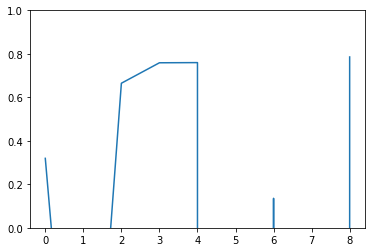

In [16]:
R2_mean_by_kernel = R2_kernel_CV.mean(axis = 1)
plt.plot(R2_mean_by_kernel)
plt.ylim(0.0, 1.0)
plt.show()

In [17]:
best_R2_idx = argmax(R2_mean_by_kernel)
best_R2 = R2_mean_by_kernel[best_R2_idx]

print('Best R2 index = ', best_R2_idx, '   best_R2 = ', best_R2,  '   Best kernel = ', kern[best_R2_idx])

Best R2 index =  8    best_R2 =  0.7856925617377511    Best kernel =  cosine


### See how the model fits

Best alpha =  0.0016584757884037238    Best gamma =  0.8179087337982628    Best kernel =  cosine
R2 =   0.8405


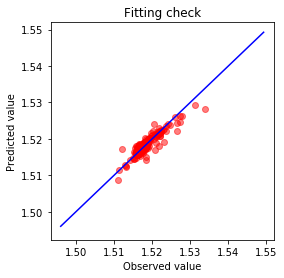

In [18]:
kernel_choince = kern[best_R2_idx]
X_train, y_train = X, y

optimizer = BayesianOptimization(f = rmse_comp_KRR, domain = bounds_KRR, acquisition_type = 'EI')
optimizer.run_optimization(max_iter = 20)


krr_best = KernelRidge(alpha = optimizer.x_opt[0], gamma = optimizer.x_opt[1], kernel = kernel_choice)
krr_best.fit(X_train, y_train)
y_pred = krr_best.predict(X)

print('Best alpha = ', optimizer.x_opt[0], '   Best gamma = ', optimizer.x_opt[1], '   Best kernel = ', kernel_choice)
print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit)
split_num = 5

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)

print('Check best model perfromance in the original folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = krr_best.predict(X_test)
    R2_reg = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_reg))

Check best model perfromance in the original folds
 0.9203
 0.7814
 0.7288
 0.8414
 0.8915
